<a href="https://colab.research.google.com/github/AlexanderKClark/MAT421/blob/main/MAT411_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling SIR to Predict COVID-19
## Alexander Clark, MAT421

## Introduction

The COVID-19 pandemic has been one of the most significant global health crises in modern history, leading to millions of deaths and unprecedented socio-economic disruption worldwide. Mathematical models are essential tools for understanding the dynamics of infectious disease spread and guiding public health interventions. Among the most foundational models is the SIR model, which classifies the population into three compartments: susceptible (S), infectious (I), and removed (R).

In this project, I apply the SIR model to study the progression of COVID-19 in three major countries: South Korea, the United States, and Brazil. These countries were selected to represent diverse outbreak trajectories, government responses, and demographic settings. South Korea implemented strict suppression strategies and contained the virus relatively quickly. The United States adopted a decentralized mitigation approach, experiencing multiple large waves. Brazil faced delayed interventions and sustained high transmission rates.

The purpose of this project is twofold:

1. To simulate the spread of COVID-19 in different countries using the SIR model and numerical methods.

2. To evaluate the accuracy of a simple compartmental model in fitting real-world data with epidemic dynamics.

## Mathematical Methods
### The SIR Model
The [SIR Model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) that will be used will be exceptionally simple; birth and death unrelated to the disease will not be considered. As such, the following system of ODEs will be used:

$
\left\{
  \begin{align*}
  \frac{dS}{dt}=&-\frac{\beta}{N}IS,\\\\
  \frac{dI}{dt}=&\frac{\beta}{N}IS-\gamma I,\\\\
  \frac{dR}{dt}=&\gamma I,
  \end{align*}
\right.
$

where $S$ is the susceptible (but not yet infected) population; $I$ is the infectious population; $R$ is the recovered (and assumed to be immune) population; $N$ is the sum of $S$, $I$, and $R$ and assumed to be constant; $\beta$ is the infection rate of the disease per day per person affected, and $\gamma$ is the recovery rate per day per infected person.

### Euler's Method
For some explicitly defined forst order ODE $\frac{dS(t)}{dt}=F(t,S(t))$, one can express the linear approximation of $S(t)$ around $t_j$ at $t_{j+1}$, which would look like $S(t_{j+1})=S(t_j)+(t_{j+1}-t_j)\frac{dS(t_j)}{dt}$, which can also be written as $S(t_{j+1})=S(t_j)+hF(t_j,S(t_j))$.

### Fourth-Order Runge-Kutta Method
The Fourth Order Runge-Kutta method (RK4) solves an initial value problem
$\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0$

by combining multiple slope estimates:

$k_1 = f(t_n, y_n)$

$k_2 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_1\right)$

$k_3 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_2\right)$

$k_4 = f(t_n + h, y_n + hk_3)$

The solution is updated by

$y_{n+1} = y_n + \frac{h}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)$

where $h$ is the time step. RK4 achieves fourth-order accuracy, $O(h^4)$.

## Implementation


In [332]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.integrate import odeint
import warnings
from scipy import optimize
from statsmodels.formula.api import ols
from scipy.optimize import differential_evolution

In [333]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

## SIR Model:

In [334]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

## Euler's Method:

In [335]:
def forward_euler(deriv, y0, t0, tf, h, N, beta, gamma):
    t = t0
    y = y0
    t_values = [t]
    y_values = [y]

    while t < tf:
        dydt = deriv(y, t, N, beta, gamma)
        y = [y[i] + h * dydt[i] for i in range(len(y))]
        t += h
        t_values.append(t)
        y_values.append(y)

    return t_values, y_values

## Fourth Order Runga-Kutta Method (RK4)

In [336]:
def runge_kutta_4(deriv, y0, t0, tf, h, N, beta, gamma):
    t = t0
    y = y0
    t_values = [t]
    y_values = [y]

    while t < tf:
        k1 = deriv(y, t, N, beta, gamma)
        k2 = deriv([y[i] + 0.5 * h * k1[i] for i in range(len(y))], t + 0.5 * h, N, beta, gamma)
        k3 = deriv([y[i] + 0.5 * h * k2[i] for i in range(len(y))], t + 0.5 * h, N, beta, gamma)
        k4 = deriv([y[i] + h * k3[i] for i in range(len(y))], t + h, N, beta, gamma)

        y = [y[i] + (h / 6) * (k1[i] + 2 * k2[i] + 2 * k3[i] + k4[i]) for i in range(len(y))]
        t += h
        t_values.append(t)
        y_values.append(y)

    return t_values, y_values

## An Attempt at Opimization
I used `odeint` to solve the SIR, `measure` to prove a metric on the solution, `r2` to evaluate the fit, and `optimize_parameters` which uses `differential_evolution` to try and optimize for $\gamma$ and $\beta$.  

In [337]:
def fit_odeint(t, beta, gamma, S0, I0, R0, N):
    y0 = (S0, I0, R0)
    sol = odeint(deriv, y0, t, args=(beta, gamma, N))
    return sol[:, 1]

# measure the solution
def measure(params, country_data, N):
    beta, gamma = params
    country_I = country_data['I']
    country_R = country_data['R']

    I0 = country_I.iloc[0]
    R0 = country_R.iloc[0]
    S0 = N - I0 - R0

    t_data = np.arange(0, len(country_I))

    I_pred = fit_odeint(t_data, beta, gamma, S0, I0, R0, N)

    sse = np.sum((country_I - I_pred)**2)

    return sse

def calculate_r2(country_data, I_pred):
    country_I = country_data['I']

    ss_total = np.sum((country_I - np.mean(country_I))**2)
    ss_residual = np.sum((country_I - I_pred)**2)
    r2 = 1 - (ss_residual / ss_total)

    return r2

def optimize_parameters(country_name, country_data, N):
    bounds = [(0.01, 1), (0.01, 1)]

    result = differential_evolution(measure, bounds, args=(country_data, N), strategy='best1bin', maxiter=1000, popsize=2000, recombination=0.7, seed=42)

    # Extract the optimal parameters
    return best_beta, best_gamma

## Data
The data that was read for this project came form the [Kaggle link](https://www.kaggle.com/code/therealcyberlord/coronavirus-covid-19-visualization-prediction) as instructed. Specifically, i used [time_series_covid19_confirmed_global.csv](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv), [time_series_covid19_deaths_global.csv](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), and [time_series_covid19_recovered_global.csv](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv). As you will see below, they contained data for many countries, and I chose South Korea, the US, and Brazil.

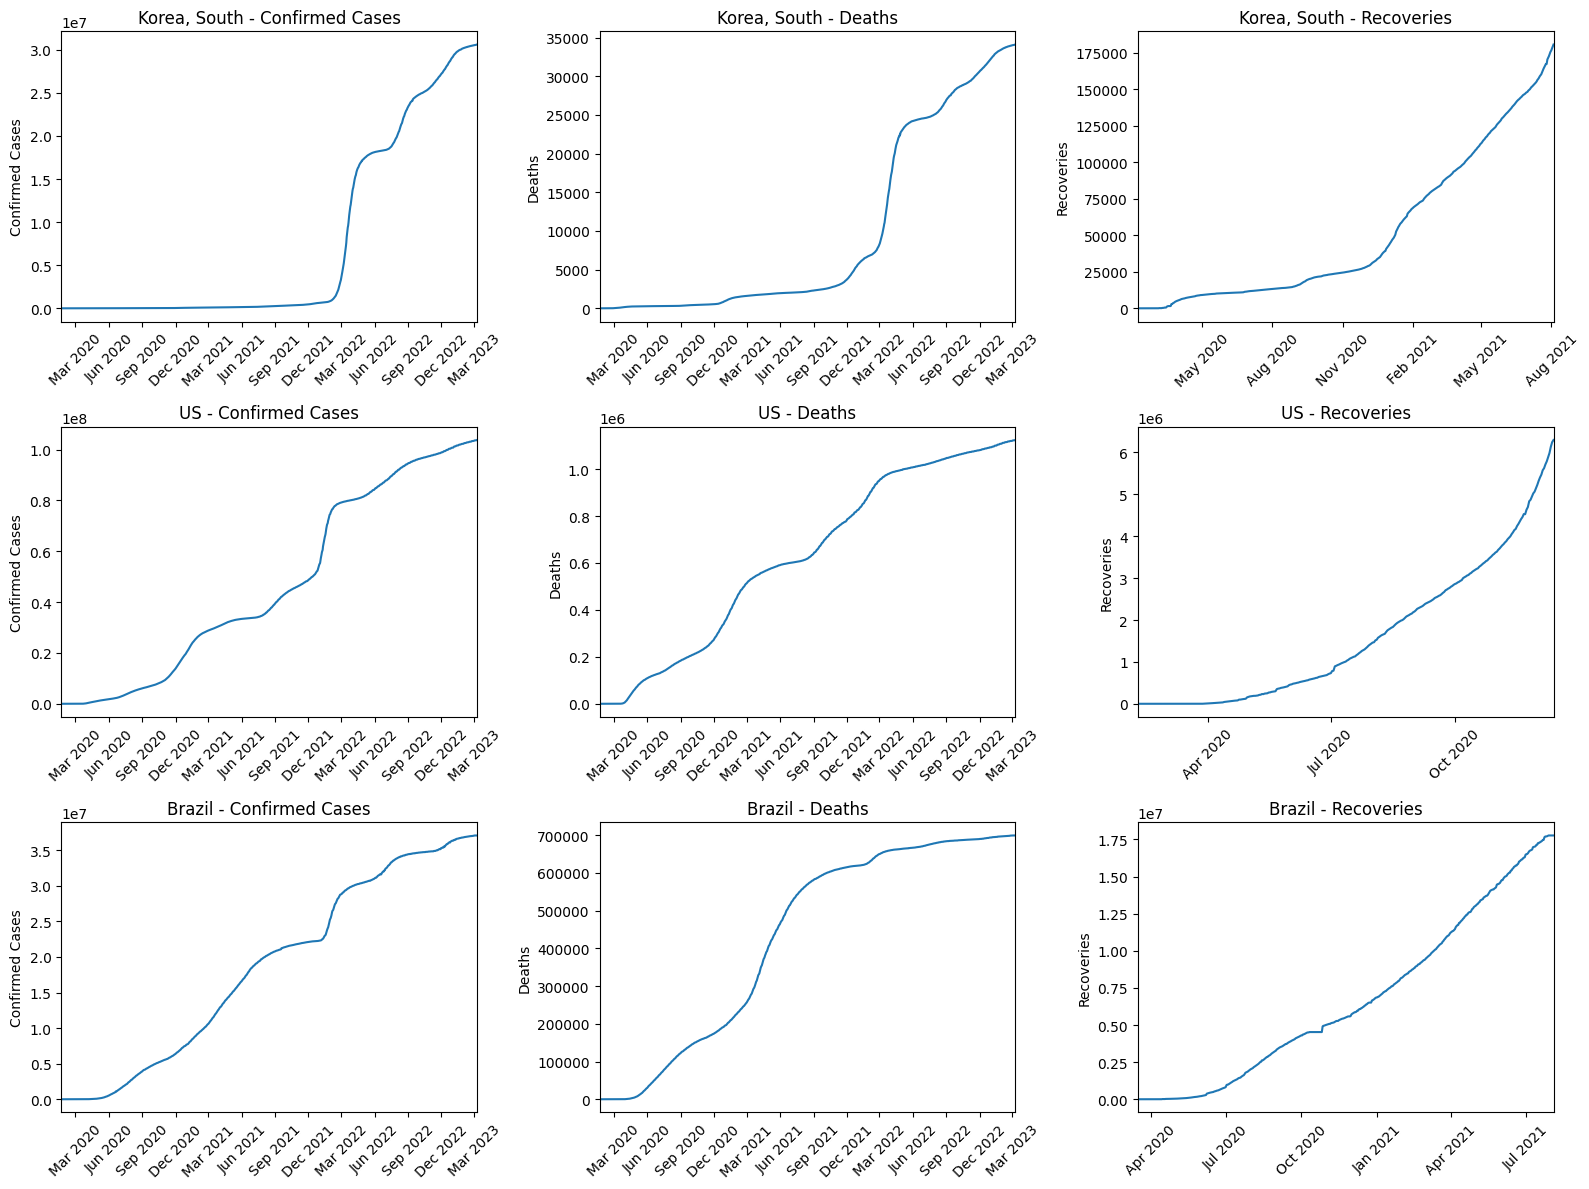


Final Values for Each Country:

Korea, South:
  Final Confirmed Cases: 30615522
  Final Deaths: 34093
  Final Recoveries: 180719

US:
  Final Confirmed Cases: 103802702
  Final Deaths: 1123836
  Final Recoveries: 6298082

Brazil:
  Final Confirmed Cases: 37076053
  Final Deaths: 699276
  Final Recoveries: 17771228


In [343]:
confirmed_df = pd.read_csv(confirmed_url)
deaths_df = pd.read_csv(deaths_url)
recovered_df = pd.read_csv(recovered_url)

countries = ['Korea, South', 'US', 'Brazil']
populations = [5.184e7,3.3e8,2.09e8]

data = {}

for country in countries: # I wanted to do China before I settled on South Korea
    confirmed = confirmed_df[confirmed_df['Country/Region'] == country].iloc[:, 4:].sum()
    deaths = deaths_df[deaths_df['Country/Region'] == country].iloc[:, 4:].sum()
    recovered = recovered_df[recovered_df['Country/Region'] == country].iloc[:, 4:].sum()

    # Filter out zero recovery values
    recovered_nonzero = recovered[recovered > 0]

    # Calculate active cases only when confirmed, deaths, and recoveries have data for accuracy
    active_cases = confirmed - deaths - recovered_nonzero

    data[country] = {
        'confirmed': confirmed,
        'confirmed_dates': confirmed.index,
        'deaths': deaths,
        'death': deaths.index,
        'recovered': recovered_nonzero,
        'recovered_dates': recovered_nonzero.index,
        'active': active_cases
        }

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

plot_titles = ['Confirmed Cases', 'Deaths', 'Recoveries']
for i, country in enumerate(countries):
    # Plot Confirmed Cases
    axes[i, 0].plot(pd.to_datetime(data[country]['confirmed'].index, format='%m/%d/%y'), data[country]['confirmed'].values)
    axes[i, 0].set_title(f"{country} - {plot_titles[0]}")
    axes[i, 0].set_ylabel('Confirmed Cases')
    axes[i, 0].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1], interval=3))
    axes[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].set_xlim(pd.to_datetime(data[country]['confirmed'].index[0]), pd.to_datetime(data[country]['confirmed'].index[-1]))

    # Plot Deaths
    axes[i, 1].plot(pd.to_datetime(data[country]['deaths'].index, format='%m/%d/%y'), data[country]['deaths'].values)
    axes[i, 1].set_title(f"{country} - {plot_titles[1]}")
    axes[i, 1].set_ylabel('Deaths')
    axes[i, 1].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1], interval=3))  #
    axes[i, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].set_xlim(pd.to_datetime(data[country]['deaths'].index[0]), pd.to_datetime(data[country]['deaths'].index[-1]))

    # Plot Recoveries
    axes[i, 2].plot(pd.to_datetime(data[country]['recovered'].index, format='%m/%d/%y'), data[country]['recovered'].values)
    axes[i, 2].set_title(f"{country} - {plot_titles[2]}")
    axes[i, 2].set_ylabel('Recoveries')
    axes[i, 2].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1], interval=3))
    axes[i, 2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    axes[i, 2].tick_params(axis='x', rotation=45)
    axes[i, 2].set_xlim(pd.to_datetime(data[country]['recovered'].index[0]), pd.to_datetime(data[country]['recovered'].index[-1]))

plt.tight_layout()
plt.show()

print("\nFinal Values for Each Country:")

for country in countries:
    final_confirmed = data[country]['confirmed'].iloc[-1]
    final_deaths = data[country]['deaths'].iloc[-1]
    final_recovered = data[country]['recovered'].iloc[-1] if not data[country]['recovered'].empty else 0

    print(f"\n{country}:")
    print(f"  Final Confirmed Cases: {final_confirmed}")
    print(f"  Final Deaths: {final_deaths}")
    print(f"  Final Recoveries: {final_recovered}")

I then calculated the active cases (e.g., the difference between the  infectious population and the removed population).

First plotted date of active cases for Korea, South: 2020-02-07 00:00:00
First plotted date of active cases for US: 2020-02-09 00:00:00
First plotted date of active cases for Brazil: 2020-03-16 00:00:00


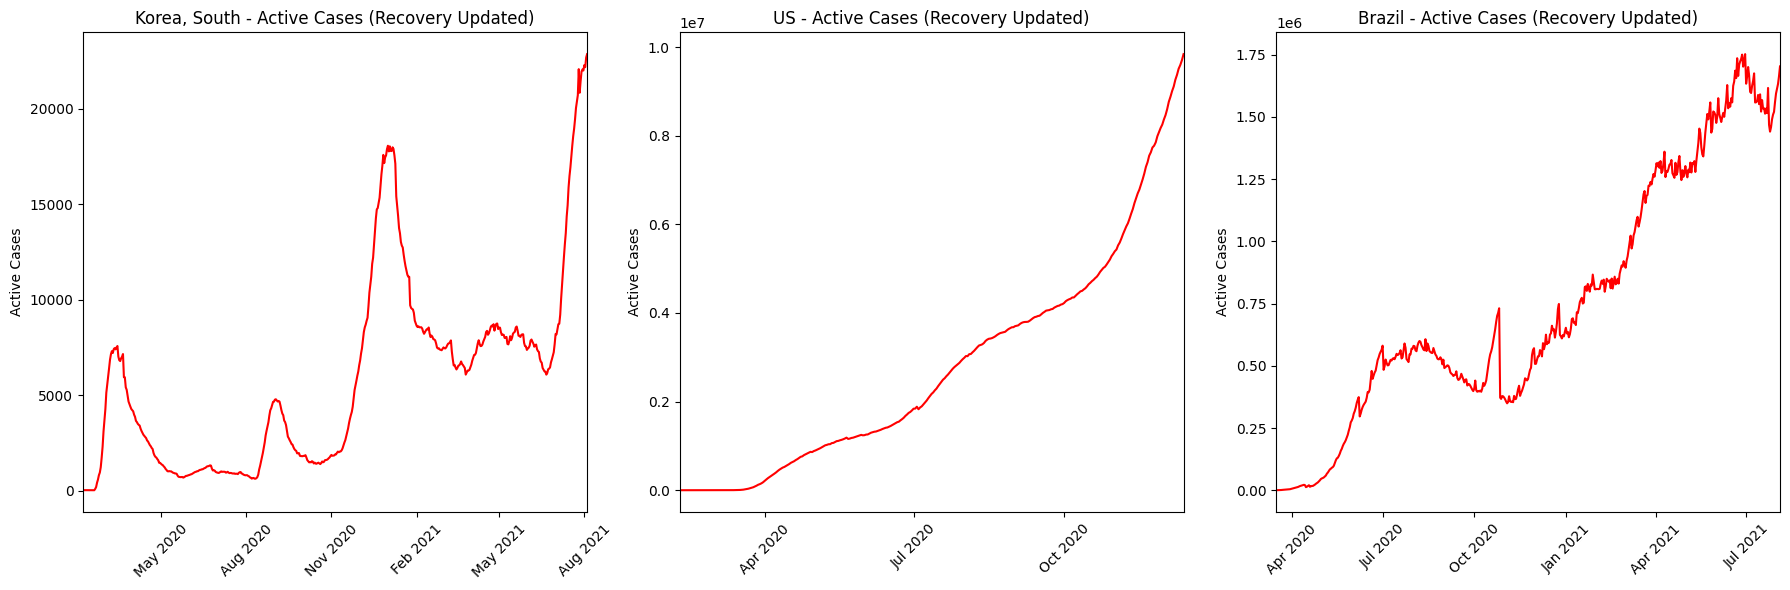

In [339]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, country in enumerate(countries):
    if country in data:

        recovery_dates = data[country]['recovered'].index

        active_cases = data[country]['active'][recovery_dates]

        # Plot Active Cases for the dates where recovery data is updated
        axes[i].plot(pd.to_datetime(active_cases.index, format='%m/%d/%y'), active_cases.values, label='Active Cases', color='red')

        first_date = pd.to_datetime(active_cases.index[0], format='%m/%d/%y')
        print(f"First plotted date of active cases for {country}: {first_date}")

        axes[i].set_title(f"{country} - Active Cases (Recovery Updated)")
        axes[i].set_ylabel('Active Cases')
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1], interval=3))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xlim(pd.to_datetime(active_cases.index[0]), pd.to_datetime(active_cases.index[-1]))

plt.tight_layout()
plt.show()

SK_I = data['Korea, South']['active'][recovery_dates]
US_I = data['US']['active'][recovery_dates]
Brazil_I = data['Brazil']['active'][recovery_dates]

SK_R = data['Korea, South']['deaths'] + data['Korea, South']['recovered']
US_R = data['US']['deaths'] + data['US']['recovered']
Brazil_R = data['Brazil']['deaths'] + data['Brazil']['recovered']

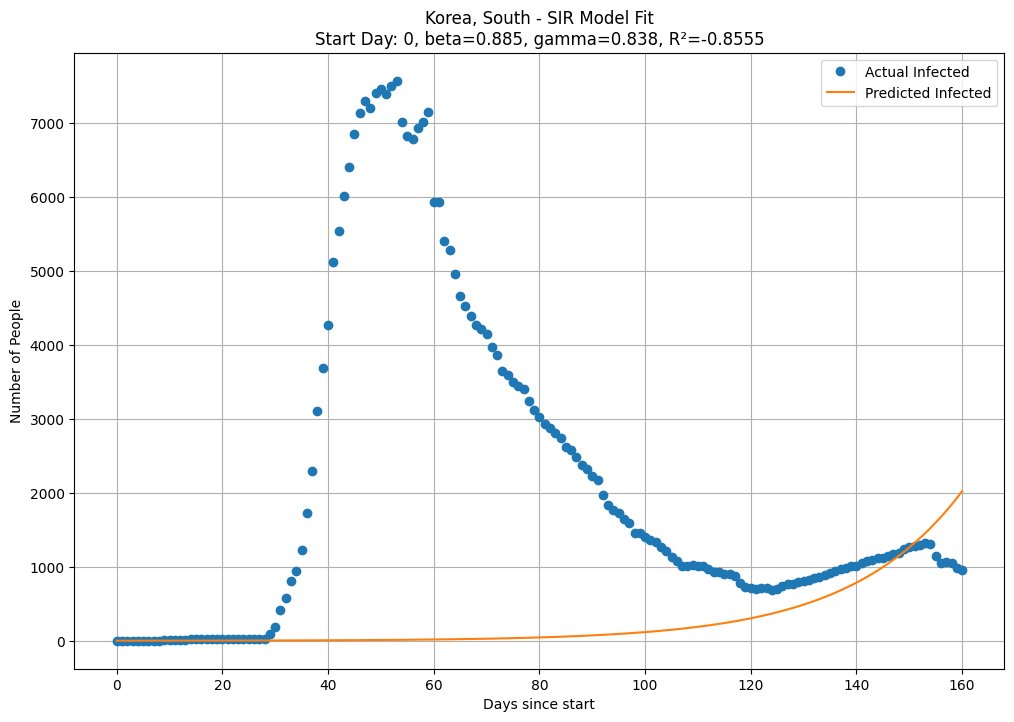

Optimal parameters for Korea, South:
beta = 0.885476
gamma = 0.837812
R² = -0.8555


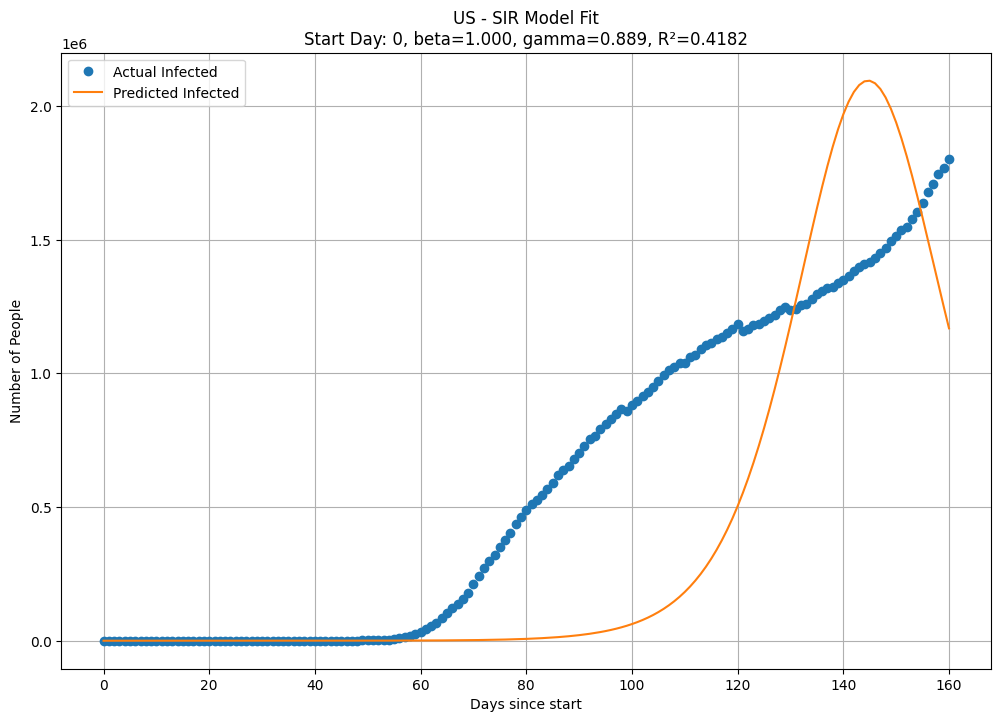

Optimal parameters for US:
beta = 1.000000
gamma = 0.889442
R² = 0.4182


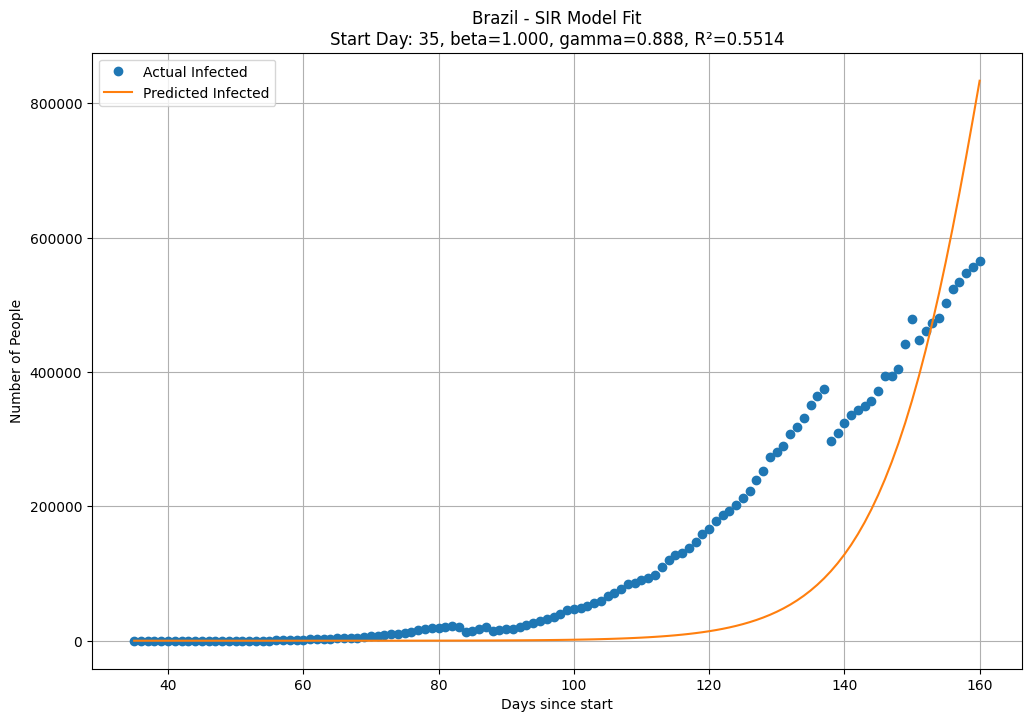

Optimal parameters for Brazil:
beta = 1.000000
gamma = 0.887503
R² = 0.5514


In [340]:
def deriv(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def fit_odeint(t, beta, gamma, S0, I0, R0, N):
    y0 = (S0, I0, R0)
    sol = odeint(deriv, y0, t, args=(beta, gamma, N))
    return sol[:, 1]

def measure(params, country_data, N):
    beta, gamma = params
    country_I = country_data['I']
    country_R = country_data['R']

    I0 = country_I.iloc[0]
    R0 = country_R.iloc[0]
    S0 = N - I0 - R0

    t_data = np.arange(0, len(country_I))

    I_pred = fit_odeint(t_data, beta, gamma, S0, I0, R0, N)

    sse = np.sum((country_I - I_pred)**2)

    return sse

def calculate_r2(country_data, I_pred):
    country_I = country_data['I']

    ss_total = np.sum((country_I - np.mean(country_I))**2)
    ss_residual = np.sum((country_I - I_pred)**2)
    r2 = 1 - (ss_residual / ss_total)

    return r2

def optimize_parameters(country_name, country_data, N):
    bounds = [(0.01, 1), (0.01, 1)]

    result = differential_evolution(measure, bounds, args=(country_data, N), strategy='best1bin', maxiter=1000, popsize=20, recombination=0.7, seed=42)

    best_beta, best_gamma = result.x
    return best_beta, best_gamma

def plot_country_data(country_data_ranges):
    for country_name, (start_day, end_day) in country_data_ranges.items():
        country_data = data[country_name]
        N = populations[country_name]

        country_data_reset = country_data.reset_index(drop=True)

        country_data_subset = country_data_reset.loc[start_day:end_day]

        best_beta, best_gamma = optimize_parameters(country_name, country_data_subset, N)

        I0 = country_data_subset['I'].iloc[0]
        R0 = country_data_subset['R'].iloc[0]
        S0 = N - I0 - R0
        t_data = np.arange(start_day, end_day + 1)
        I_pred = fit_odeint(t_data, best_beta, best_gamma, S0, I0, R0, N)

        r2 = calculate_r2(country_data_subset, I_pred)

        plt.figure(figsize=(12, 8))
        plt.plot(t_data, country_data_subset['I'], 'o', label='Actual Infected')
        plt.plot(t_data, I_pred, '-', label='Predicted Infected')
        plt.xlabel('Days since start')
        plt.ylabel('Number of People')
        plt.title(f'{country_name} - SIR Model Fit\nStart Day: {start_day}, beta={best_beta:.3f}, gamma={best_gamma:.3f}, R²={r2:.4f}')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Optimal parameters for {country_name}:")
        print(f"beta = {best_beta:.6f}")
        print(f"gamma = {best_gamma:.6f}")
        print(f"R² = {r2:.4f}")

def get_country_data(country_name, confirmed_df, deaths_df, recovered_df):
    confirmed_country = confirmed_df[confirmed_df['Country/Region'] == country_name].iloc[:, 4:].sum()
    deaths_country = deaths_df[deaths_df['Country/Region'] == country_name].iloc[:, 4:].sum()
    recovered_country = recovered_df[recovered_df['Country/Region'] == country_name].iloc[:, 4:].sum()

    country_data = pd.DataFrame({
        'I': confirmed_country - deaths_country - recovered_country,
        'R': recovered_country + deaths_country
    })

    return country_data

populations = {'Korea, South': 51840000, 'US': 330000000, 'Brazil': 209000000}

countries = ['Korea, South', 'US', 'Brazil']
data = {country: get_country_data(country, confirmed_df, deaths_df, recovered_df) for country in countries}

country_data_ranges = {
    'Korea, South': (0, 160),
    'US': (0, 160),
    'Brazil': (35, 160)
}

plot_country_data(country_data_ranges)

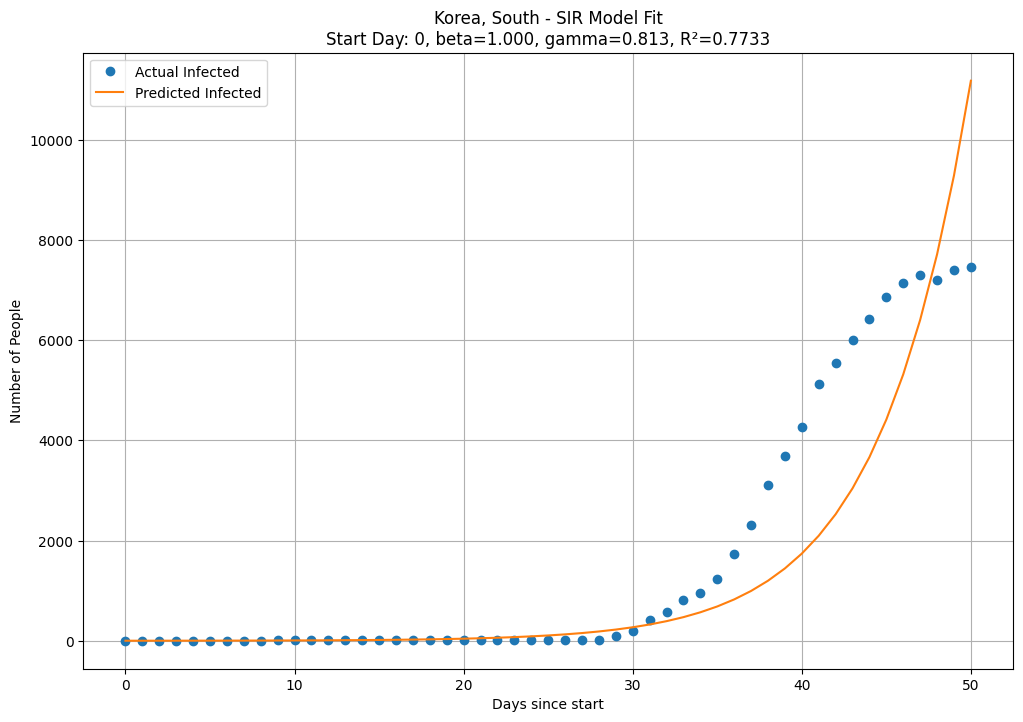

Optimal parameters for Korea, South:
beta = 1.000000
gamma = 0.813436
R² = 0.7733


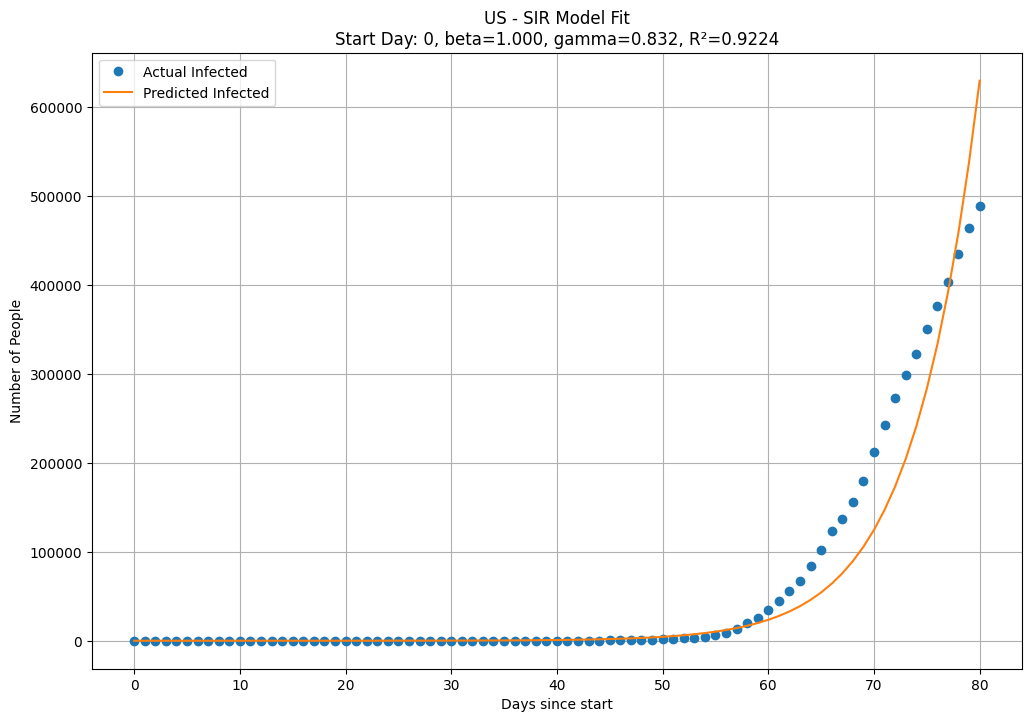

Optimal parameters for US:
beta = 1.000000
gamma = 0.832205
R² = 0.9224


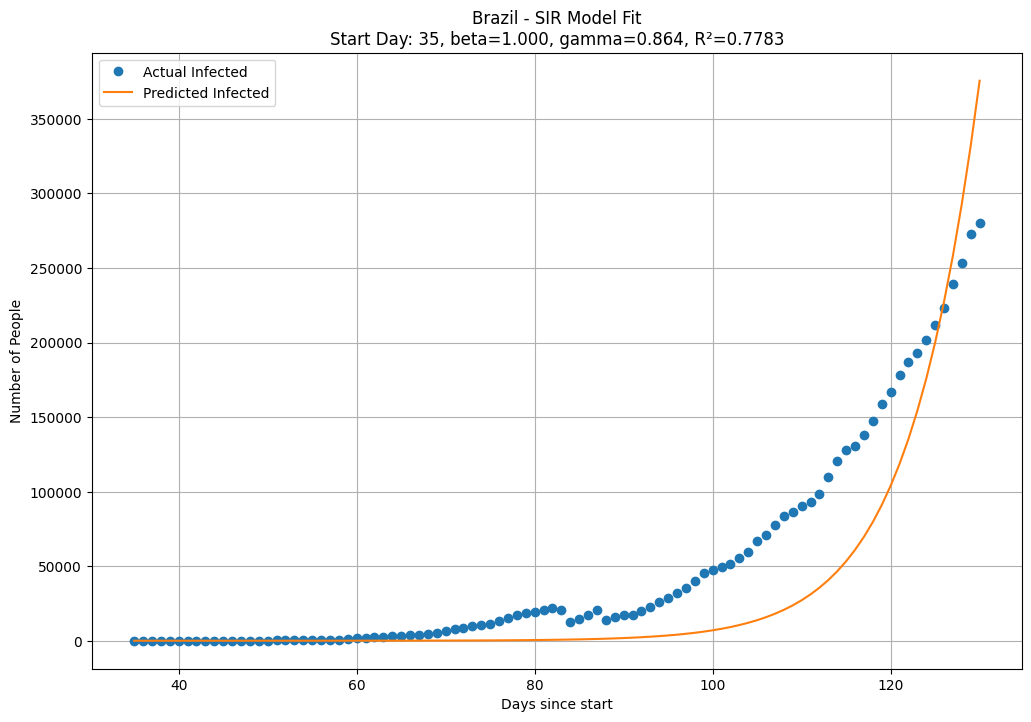

Optimal parameters for Brazil:
beta = 1.000000
gamma = 0.863783
R² = 0.7783


In [341]:
def plot_country_data(country_data_ranges):
    for country_name, (start_day, end_day) in country_data_ranges.items():
        country_data = data[country_name]
        N = populations[country_name]
        country_data_reset = country_data.reset_index(drop=True)


        country_data_subset = country_data_reset.loc[start_day:end_day]


        best_beta, best_gamma = optimize_parameters(country_name, country_data_subset, N)


        I0 = country_data_subset['I'].iloc[0]
        R0 = country_data_subset['R'].iloc[0]
        S0 = N - I0 - R0
        t_data = np.arange(start_day, end_day + 1)
        I_pred = fit_odeint(t_data, best_beta, best_gamma, S0, I0, R0, N)

        r2 = calculate_r2(country_data_subset, I_pred)

        plt.figure(figsize=(12, 8))
        plt.plot(t_data, country_data_subset['I'], 'o', label='Actual Infected')
        plt.plot(t_data, I_pred, '-', label='Predicted Infected')
        plt.xlabel('Days since start')
        plt.ylabel('Number of People')
        plt.title(f'{country_name} - SIR Model Fit\nStart Day: {start_day}, beta={best_beta:.3f}, gamma={best_gamma:.3f}, R²={r2:.4f}')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Optimal parameters for {country_name}:")
        print(f"beta = {best_beta:.6f}")
        print(f"gamma = {best_gamma:.6f}")
        print(f"R² = {r2:.4f}")

data = {country: get_country_data(country, confirmed_df, deaths_df, recovered_df) for country in countries}

country_data_ranges = {
    'Korea, South': (0, 50),
    'US': (0, 80),
    'Brazil': (35, 130)
}

plot_country_data(country_data_ranges)

Above are the results of several attempts to fit the parameters $\gamma$ and $\beta$ to COVID-19 case data, using two distinct time intervals: first, from day 0 to day 160 of the recorded data (or, for Brazil, beginning 35 days into the dataset, since Brazil—according to the source—did not record any cases before that point), and second, a shorter interval chosen because the case numbers over that range exhibited a local behavior resembling exponential growth. The second interval was intended to give the fitting procedure the best possible chance at success by approximating the assumptions underlying the SIR model.

Despite these efforts, the parameter values obtained through the fitting process were often clearly nonsensical. Most notably, the fitted $\beta$ values were exceedingly large, 1 or values very near 1. Such a result is physically implausible. A $\beta$ value of 1 would imply that each infected individual infects another person every day with near certainty, a transmission rate far higher than any realistic estimate for COVID-19. The disease, while highly contagious, does not spread with that kind of inevitability on a daily basis, especially when public health interventions and changes in behavior (such as mask-wearing and social distancing) are taken into account.

Similarly, the values obtained for $\gamma$ were equally problematic. The inferred $\gamma$ suggested an average recovery time of approximately $\frac{1}{0.8}=1.25$ days, meaning that individuals would, on average, recover from COVID-19 a little over one day after becoming infected. This, too, is starkly inconsistent with known medical data. For example, in the United States, it was commonly reported that COVID-19 infections required an isolation or recovery period of at least 14 days, suggesting a $\gamma$ value closer to $\frac{1}{14}\approx0.07$, an order of magnitude smaller than the fitted values. Such discrepancies strongly indicate that the fitting process failed to capture the true dynamics of the disease.

One major contributing factor to these failures, which I did not fully consider until later in the project, was that the fitting was performed against recorded case data without any attempt to account for underreporting.  It would be unreasonable to assume that only those recorded would be infected. A combination of limited testing capacity, asymptomatic cases, misdiagnosis, and general reporting delays almost certainly meant that the true number of infections was much higher than the data suggested. As a result, the effective size of the susceptible population was systematically overestimated, while the infected population was underestimated, distorting the fitting process and leading to inflated estimates of $\beta$ and $\gamma$.

Even had I recognized this earlier, I do not see a straightforward way to correct it. Adjusting the dataset to account for underreporting would require introducing new assumptions about the scale of underreporting, which in turn would demand external epidemiological studies or estimates—resources that were outside the scope of this project. Furthermore, any such correction would introduce its own uncertainties and potential biases, complicating the interpretation of the fitted parameters even further. Thus, while the issue of underreporting critically undermines the accuracy of the model fitting, remedying it in a principled way remains a nontrivial problem, especially when the goal is to remain closely tied to the available data.

i have come to conclude that the implausible parameter estimates obtained reflect fundamental limitations not only in the modeling process I followed but also in the quality and completeness of the underlying data. Without properly addressing the gap between recorded cases and true infections, any parameter fitting exercise using SIR models is bound to yield questionable results, regardless of the care taken in selecting fitting intervals.

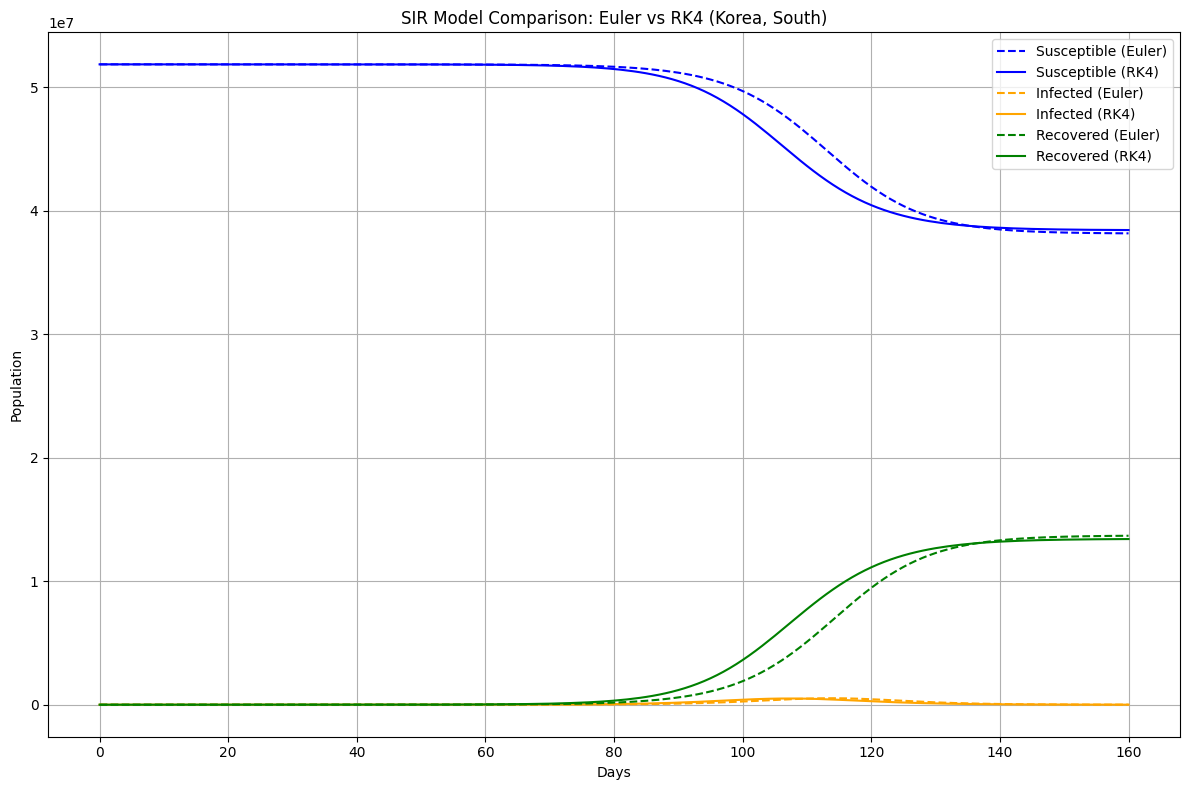

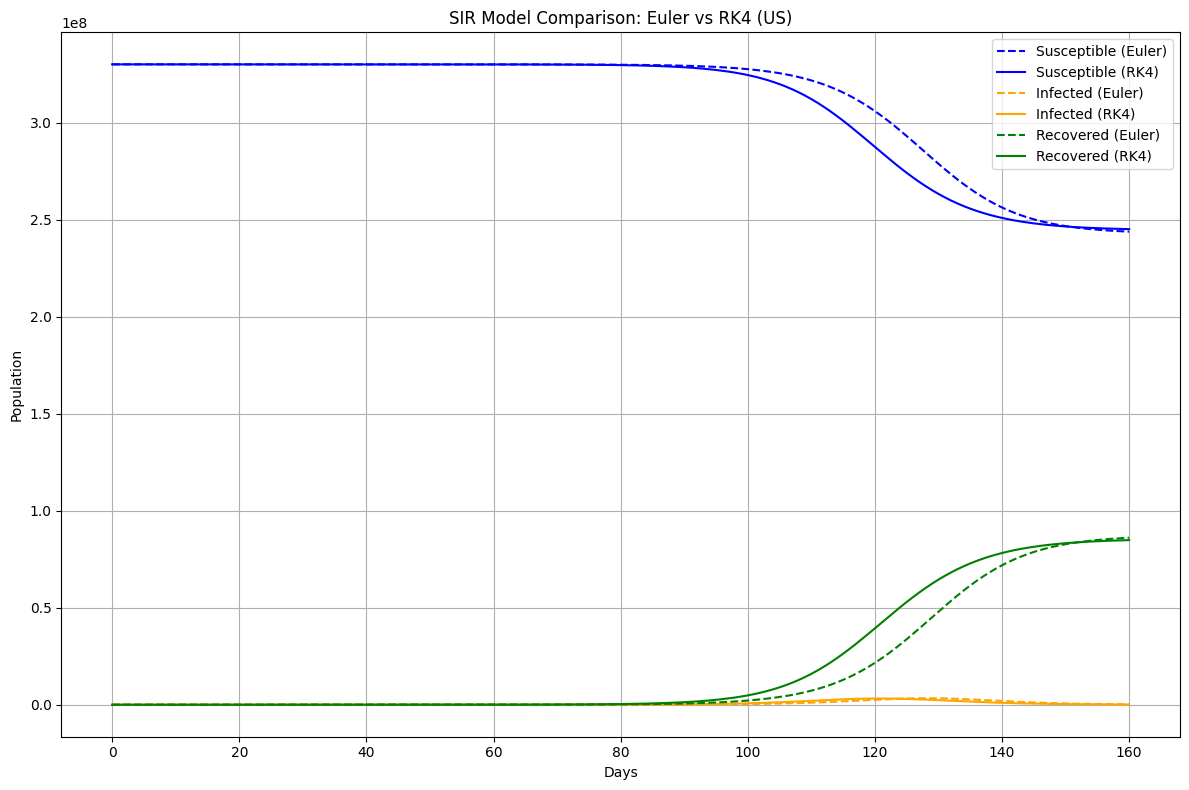

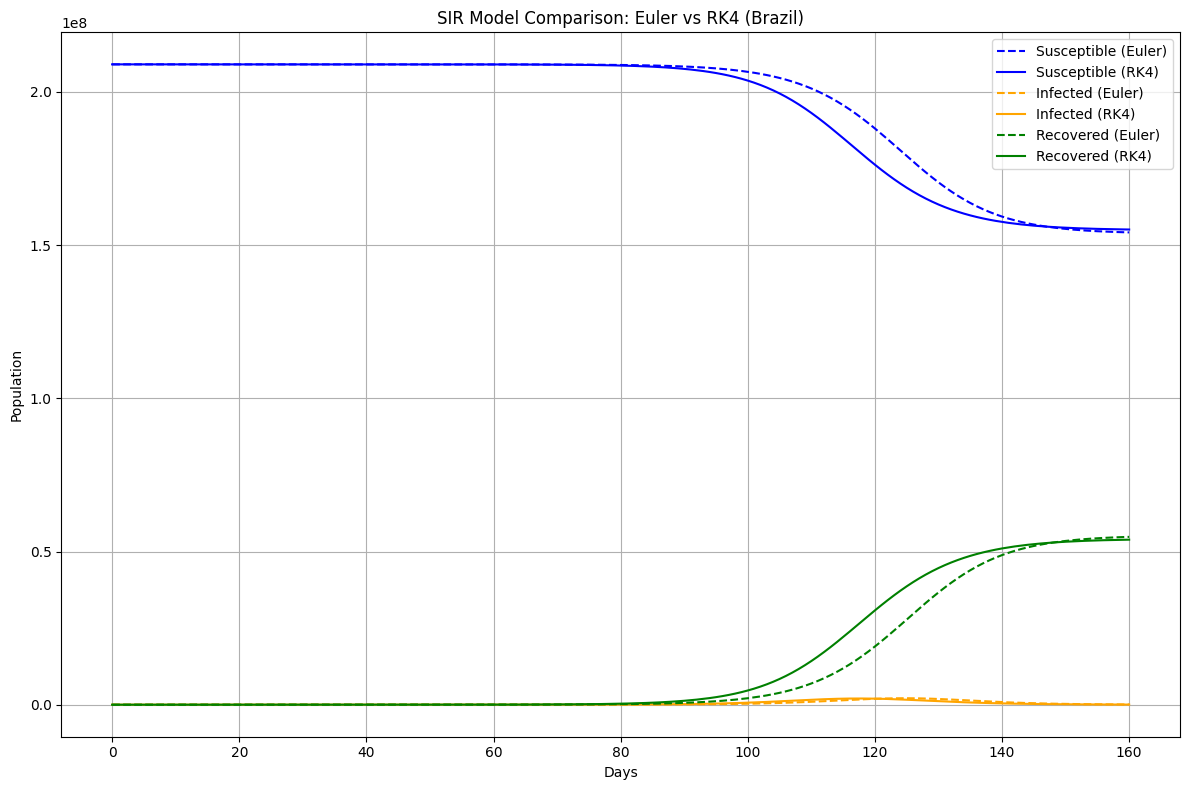

In [342]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

populations = {'Korea, South': 5.184e7, 'US': 3.3e8, 'Brazil': 2.09e8}
beta = 1
gamma = .864
I0 = 1
R0 = 0
dt = 1
days = 160

for country, N in populations.items():
    S0 = N - I0 - R0
    y0 = [S0, I0, R0]
    t0 = 0


    t_euler, y_euler = forward_euler(deriv, y0, t0, days, dt, N, beta, gamma)
    t_rk4, y_rk4 = runge_kutta_4(deriv, y0, t0, days, dt, N, beta, gamma)

    S_euler, I_euler, R_euler = zip(*y_euler)
    S_rk4, I_rk4, R_rk4 = zip(*y_rk4)

    plt.figure(figsize=(12, 8))

    plt.plot(t_euler, S_euler, label="Susceptible (Euler)", color="blue", linestyle='--')
    plt.plot(t_rk4, S_rk4, label="Susceptible (RK4)", color="blue", linestyle='-')
    plt.plot(t_euler, I_euler, label="Infected (Euler)", color="orange", linestyle='--')
    plt.plot(t_rk4, I_rk4, label="Infected (RK4)", color="orange", linestyle='-')
    plt.plot(t_euler, R_euler, label="Recovered (Euler)", color="green", linestyle='--')
    plt.plot(t_rk4, R_rk4, label="Recovered (RK4)", color="green", linestyle='-')

    plt.xlabel("Days")
    plt.ylabel("Population")
    plt.title(f"SIR Model Comparison: Euler vs RK4 ({country})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

I would like to sufficiently answer the prompt for this and meaningfully compare the numerical solutions with the actual reported cases. The goal was to determine see if any of the strategies that the countries I had chose were more conducive to being accurately modeled. However, due to the unrealistic $\gamma$ and $\beta$ values obtained in the initial fitting process, both numerical methods produced solutions that were dominated by the same modeling inaccuracies. As a result, any difference between the methods was trivial in comparison to the fundamental errors introduced by my poor methodology.

While RK4 is theoretically more accurate than Euler's method (with error on the order of $O(h^4)$), this advantage was overshadowed by the incorrect parameterization of the SIR model. The model's assumptions did not hold in real-world scenarios, further compounding the model's limitations. I would like to claim that RK4 would be the more accurate numerical method to compare to the data, but I cannot in good faith do so as I have little substantial evidence.

In summary, while the choice of numerical method is important in computational modeling, the model's structure and parameter accuracy are the primary drivers of predictive validity. Therefore, a meaningful comparison between Euler and RK4 was not feasible with the data and assumptions at hand. Future work would need more realistic parameter estimates and a refined model to evaluate numerical methods effectively.

## References
1. https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model
2. AlQadi, H., & Bani-Yaghoub, M. (2022). Incorporating global dynamics to improve the accuracy of disease models: Example of a COVID-19 SIR model. PloS one, 17(4), e0265815. https://doi.org/10.1371/journal.pone.0265815
3. My notes and that from the [textbook](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/Index.html)
4. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html